In [1]:
from bonsai.chroma import plot, color_create

%load_ext autoreload
%autoreload 2

Updated at 06/23/2020, 16:15:16


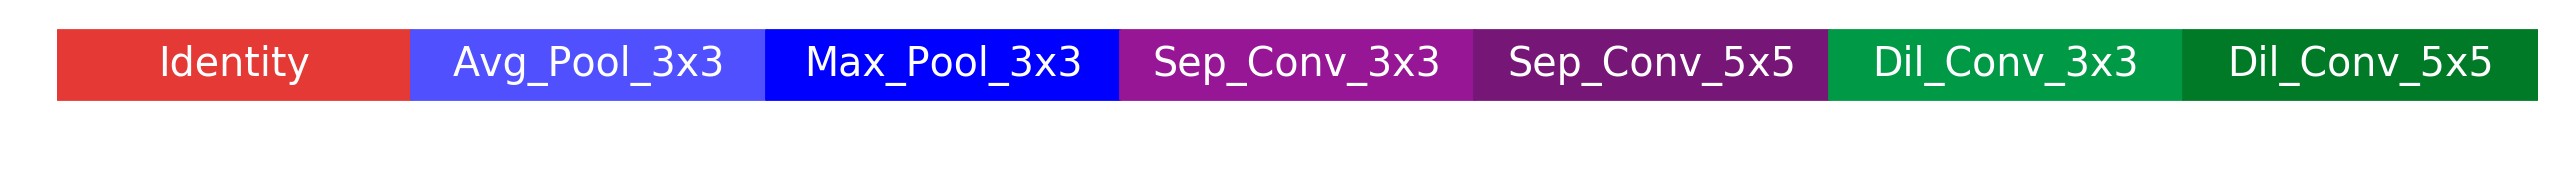

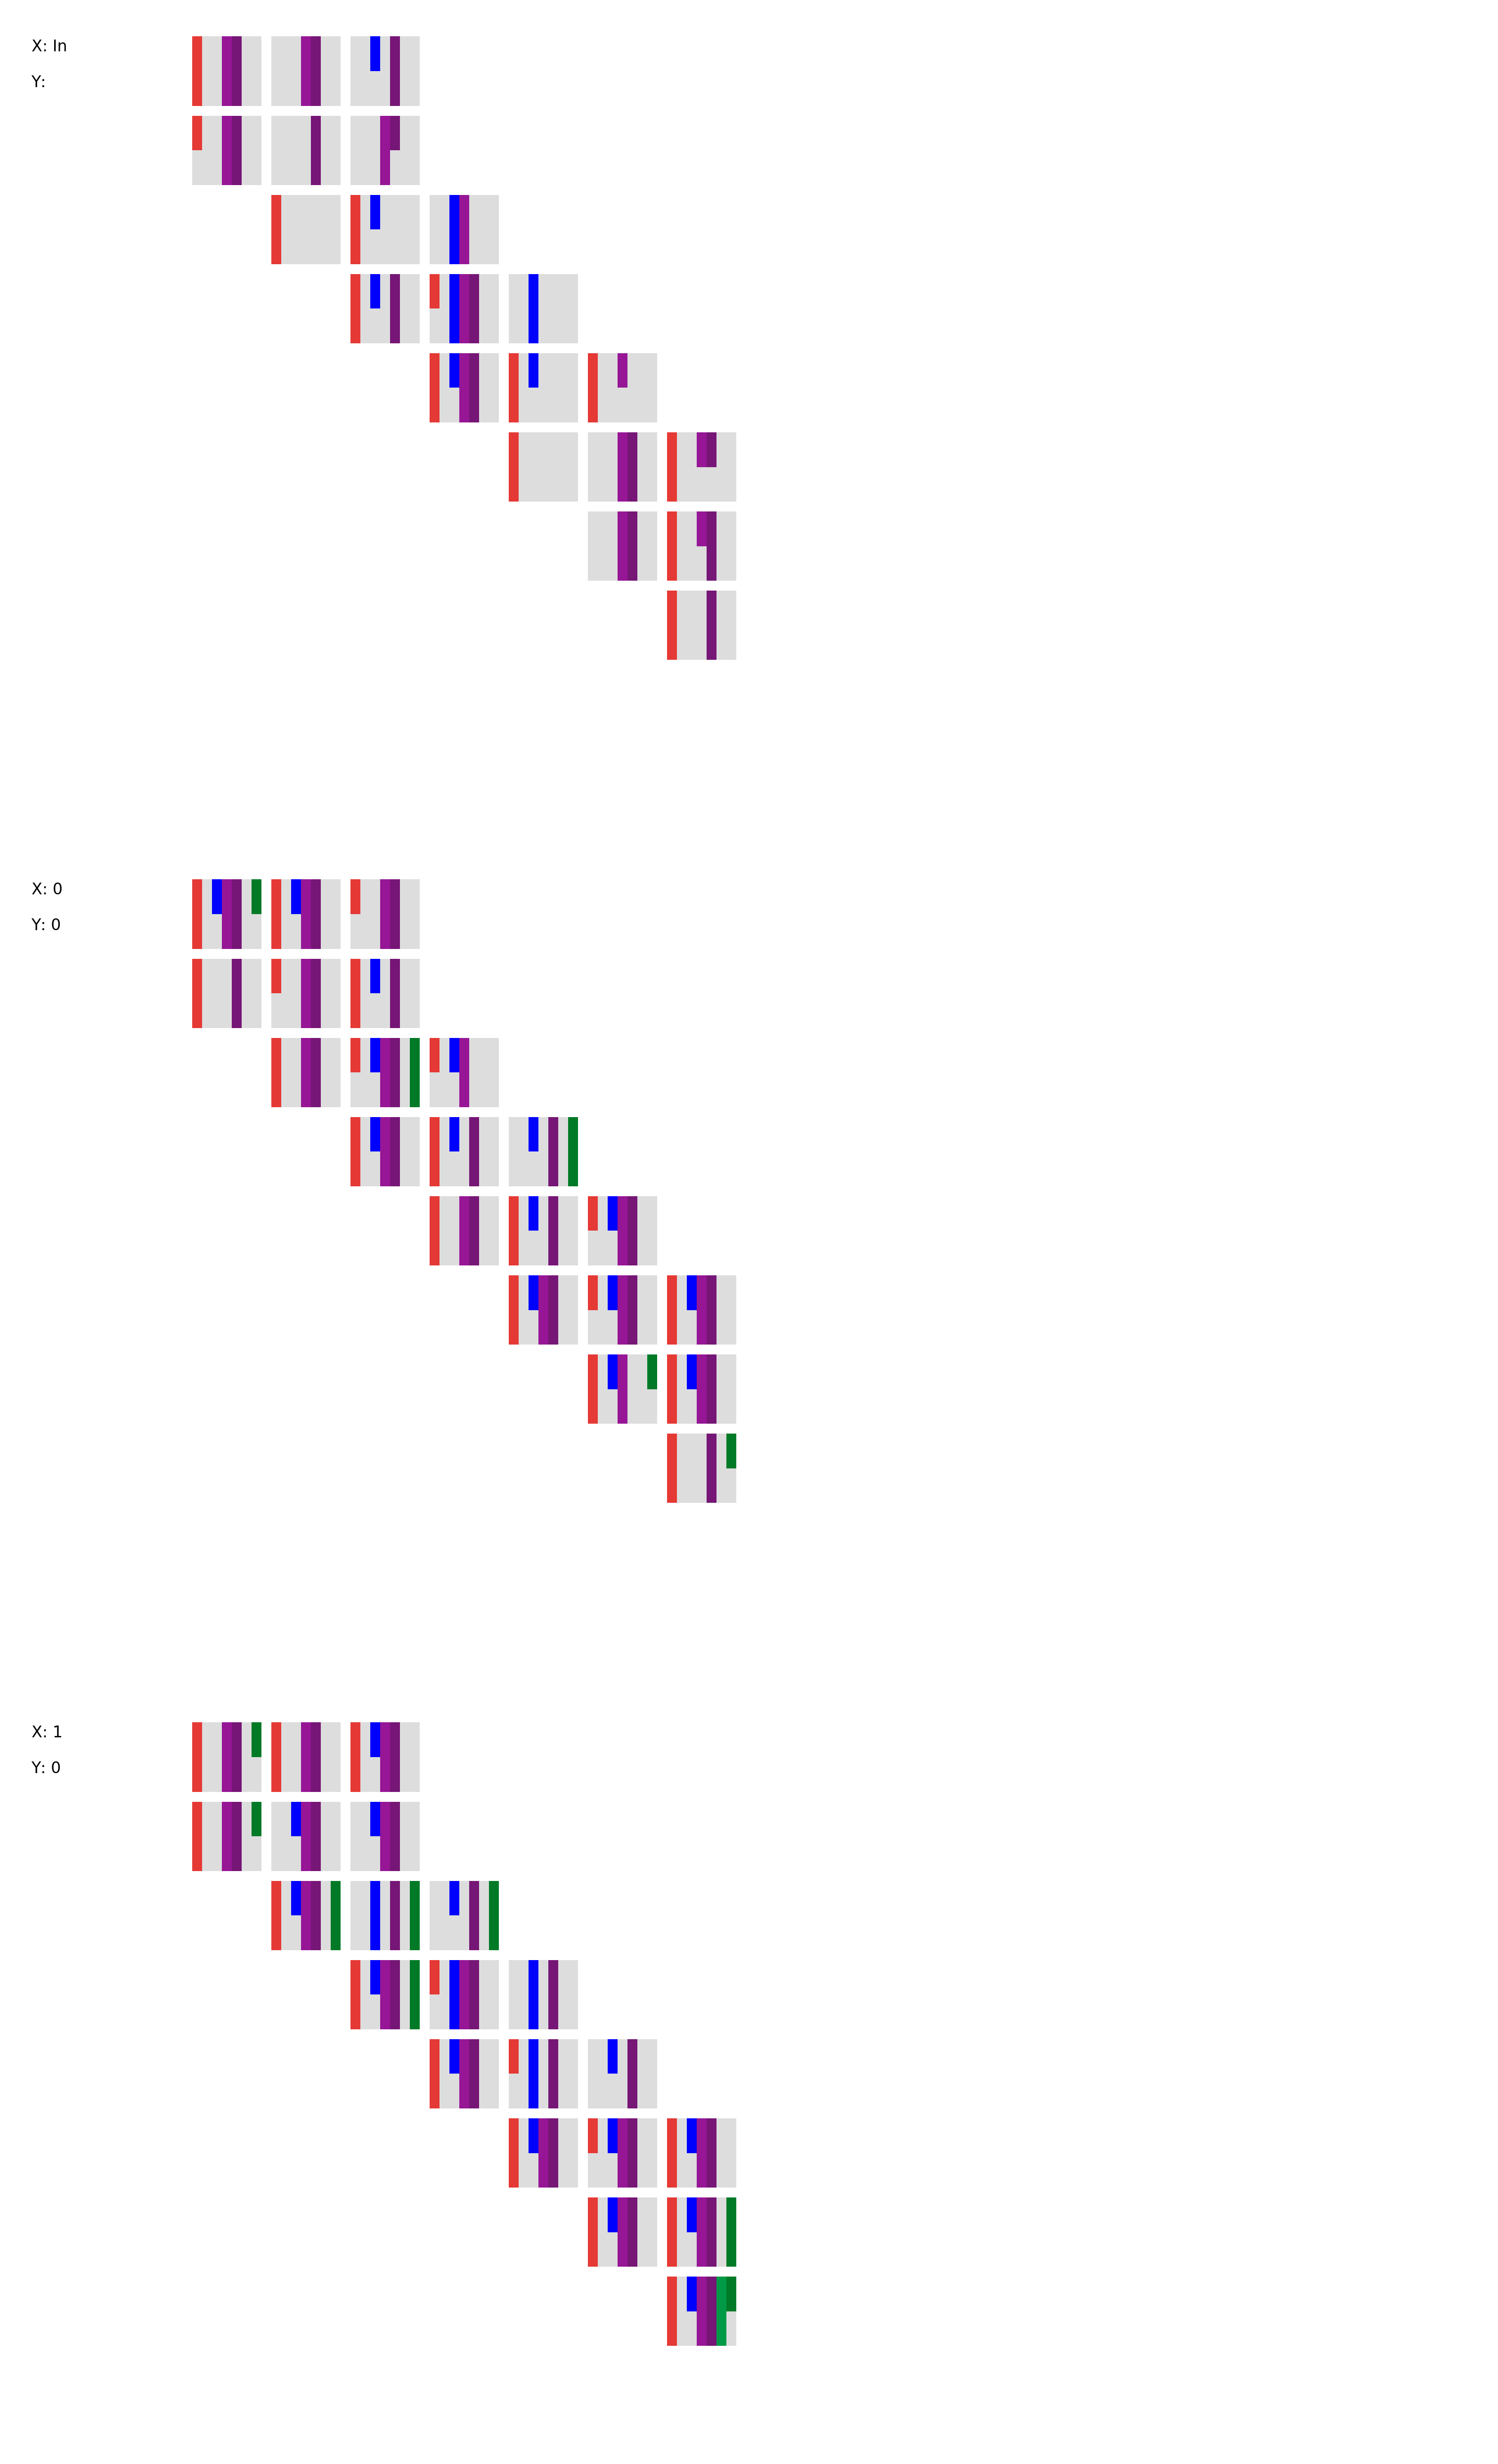

In [ ]:
plot()